# Prophet 

# What is Prophet? 

Prophet is a Python and R [open source library](https://github.com/facebook/prophet) released by Facebook’s Core Data Science team, released in 2017. It is also by far the most popular time series forecasting framework for Python: it has a whopping 13.4k stars on GitHub, and tops the list of the `forecasting` [topic](https://github.com/topics/forecasting) on GitHub, with more than 10k stars compared to the second runner, `sktime`. Many of the - unofficial - PyPi rankings [such as this one](https://hugovk.github.io/top-pypi-packages/) put it at over one million monthly downloads.

The goal of Prophet is to provide a quick yet effective way to produce forecasts *at scale*, i.e. with hundreds if not thousands of time series at a time. Working under these conditions implies manual hyperparameter tuning for ARIMA models is not feasible and, at the same time, training resource intensive neural networks translates in huge expenditures. In other words, Prophet claims to strike a balance, using a generalised additive model (GAM) that combines four components. As explained on the official documentation:

> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet should work best with medium-to-high frequency data, with overlapping seasonal patterns. After all, it was designed to suit Facebook's business need.

# Controversy about Prophet

# Import Libraries

In [76]:
# data manipulation
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# prophet library
from prophet import Prophet

# to perform train-test split
from sktime.forecasting.model_selection import temporal_train_test_split

# set settings for seaborn
sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")  # will be useful later

# visualise plots inline
%matplotlib inline

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.dpi"] = 100

# Define Metrics 

In [21]:
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_absolute_scaled_error,
    mean_squared_error,
)


def model_diagnostics(
    y_pred: pd.Series,
    y_true: pd.Series,
    y_train: pd.Series,
    mase: bool = True,
) -> pd.DataFrame:

    metrics = ["MAE", "RMSE", "MAPE"]

    scores = [
        mean_absolute_error(y_true, y_pred),
        mean_squared_error(y_true, y_pred, square_root=True),
        mean_absolute_percentage_error(y_true, y_pred, symmetric=False),
    ]

    if mase:
        metrics.append("MASE")
        scores.append(mean_absolute_scaled_error(y_true, y_pred, y_train=y_train))

    return pd.DataFrame({"metrics": metrics, "scores": scores})

# Load Data 

One of the silliest features of Prophet is that it **requires** the input data to be two columns named `ds` (as in `datetime stamp`) and `y` - i.e., does not accept an index.

In [22]:
rentals = (
    pd.read_csv("../data/bikemi_csv/daily_outflow.csv", index_col=[0], parse_dates=[0])
    .asfreq("D")
    .reset_index()
    .rename({"giorno_partenza": "ds", "count": "y"}, axis=1)
)

y_train, y_test = temporal_train_test_split(rentals, test_size=0.1)

# Prophet Model 

## Fit Model 

In [23]:
model = Prophet()
model.fit(y_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -54.6289
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       370.839   1.15645e-06       68.1063   1.602e-08       0.001      154  LS failed, Hessian reset 
      99       370.839   1.58122e-07       65.7099      0.4235      0.4235      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       370.839   1.44635e-07       72.2356   2.154e-09       0.001      231  LS failed, Hessian reset 
     108       370.839   5.18131e-09       57.2473      0.2782      0.2782      235   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


## Define Forecasting Horizon

In [77]:
# forecasting horizon size
fh_size = y_test.shape[0]

fh = model.make_future_dataframe(periods=fh_size)

## Forecast

In [29]:
y_pred = model.predict(fh)

# Plot 

We can plot the results directly, by passing our forecast dataframe (`y_pred`) as the sole argument of the `plot()` funciton.

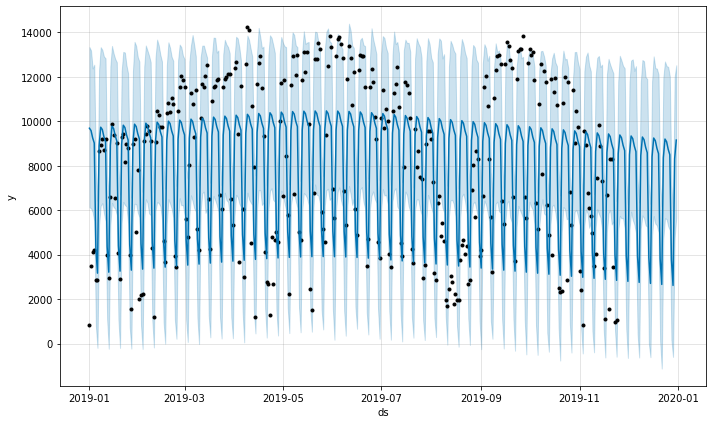

In [37]:
model.plot(y_pred)

plt.show()

We can obtain interactive plots with the in-library functions:

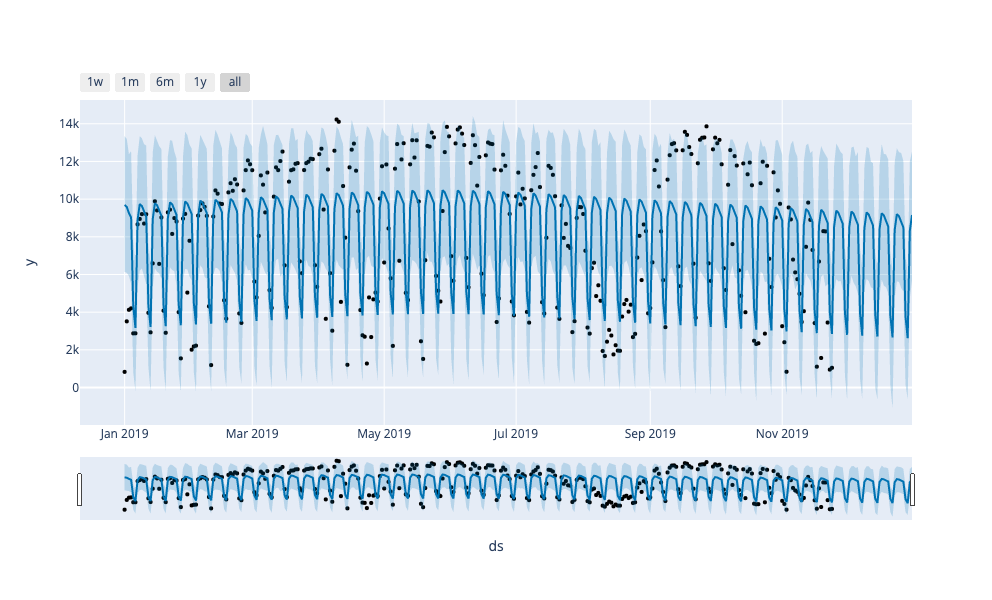

In [38]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, y_pred)

The problem with these plots is that there is no easy way of including the test data (`y_test`)

In [74]:
from typing import List

from sktime.utils.plotting import plot_series


def sktime_plot_prophet(
    y_train,
    y_test,
    y_pred,
    fh_size: int,
    labels: List[str] = ["observed", "true data", "prophet_model"]) -> plt.Figure:

    sk_y_train = y_train.set_index("ds")
    sk_y_test = y_test.set_index("ds")
    sk_y_pred = y_pred[["ds", "yhat"]].set_index("ds").iloc[-fh_size:]

    return plot_series(
        sk_y_train,
        sk_y_test,
        sk_y_pred,
        labels=labels)



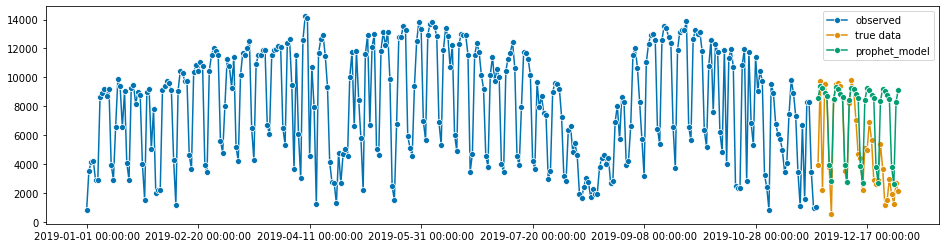

In [75]:
sktime_plot_prophet(y_train, y_test, y_pred, fh_size)

plt.show()